In [1]:
import numpy as np
import scipy as sp
import scipy.special
from KGInt import integrate, integrate_GPU, setGPU
import h5py as h5
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

## Table

KGInt calculates $\mathcal{L}(r,\alpha)$

We need: 
\begin{equation}
\frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-\frac{1}{2}|\boldsymbol {q}R|^\alpha}=\mathcal{L}(\boldsymbol{r}, \alpha, 2^{-\frac{1}{\alpha}}R)
\end{equation}

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha, 1\bigg)=\frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha\bigg)
\end{equation}

## Asymptotics

In [2]:
def asym_bx(x, alpha, n=10):
    s = 0.0
    for k in range(1, n+1):
        s += (-1)**(k+1)*(sp.special.gamma(alpha*k)/sp.special.gamma(k))*np.sin(0.5*np.pi*alpha*k)*(k*alpha+1)/x**(k*alpha+3)
    return s*alpha/(2*np.pi**2)

def asym_sx(x, alpha, n=10):
    s = 0.0
    for k in range(n):
        s += (sp.special.gamma((k+3)/alpha)/sp.special.gamma(k+3))*np.sin(0.5*np.pi*(k+3))*(k+2)*(k+1)*x**k
    return -s/(2*np.pi**2*alpha)

## Creating table

In [3]:
def gpu_calc(alpha, rrange, error, error_rng, blocks=5, threads=512, log=False):
    if log:
        gpu_rs     = np.logspace(rrange[0], rrange[1], blocks*threads, np.double)
    else:
        n = 0
        small = np.array([rrange[0]])
        if rrange[0]<0.5:
            n = int(-np.floor(np.log10(rrange[0]))*32)
            small = np.logspace(np.log10(rrange[0]), -0.3,n)
        gpu_rs     = np.linspace(rrange[0], rrange[1], blocks*threads-n, np.double)
        gpu_rs     = np.concatenate((small,gpu_rs))
    gpu_alphas     = np.array([alpha]*len(gpu_rs), np.double)
    gpu_errors     = np.array([error]*len(gpu_rs), np.double)
    gpu_error_rngs = np.array([error_rng]*len(gpu_rs), np.double)
    result_gpu = integrate_GPU(blocks, threads, gpu_rs, gpu_alphas, gpu_errors, gpu_error_rngs)
    return gpu_rs, result_gpu

def cpu_calc(alpha, rrange, error, error_rng, N=32):
    cpu_rs         = np.linspace(rrange[0], rrange[1], N, np.double)
    cpu_alphas     = np.array([alpha]*len(cpu_rs), np.double)
    cpu_errors     = np.array([error]*len(cpu_rs), np.double)
    cpu_error_rngs = np.array([error_rng]*len(cpu_rs), np.double)
    result_cpu = integrate(cpu_rs, cpu_alphas, cpu_errors, cpu_error_rngs)
    return cpu_rs, result_cpu
    
    
def getLr(alpha, shift_maxr_gpu=0, min_gpu_error_exp=7):
    series_n   = 10
    error      = 1e-8
    error_rng  = 1e-12
    cpu_error  = 1e-10
    cpu_max_division = 128
    gpu_blocks = 5
    gpu_threads = 512
    
    if alpha<0.8:
        shift_maxr_gpu = 0
    
    maxr_gpu   = alpha*10.+shift_maxr_gpu
    rs         = np.array([maxr_gpu-0.5*i for i in range(1,12) if (maxr_gpu-0.5*i)>0], np.double)
    alphas     = np.array([alpha]*len(rs), np.double)
    errors     = np.array([pow(10, -min(maxr_gpu, min_gpu_error_exp))]*len(rs), np.double)
    error_rngs = np.array([error_rng]*len(rs), np.double)
    print("*Find GPU r maximum! Target r max = ", rs, flush=True)
    print("  GPU integral error set to ", errors[0],flush=True)
    result_gpu = integrate_GPU(1, len(rs), rs, alphas, errors, error_rngs)
    print("  CPU integral error set to ", cpu_error,flush=True)
    result_cpu = integrate(rs, alphas, errors*cpu_error/errors[0], error_rngs/1e2)
    

    gcDiff   = abs(result_gpu-result_cpu)[:,0]
    i        = np.min((np.arange(len(gcDiff))+1)*np.array(gcDiff<error))-1
    maxr_gpu = rs[i]
    
    print("  GPU maximum r = %f, CPU value=%fe-5, GPU value=%fe-5, DIFF=%fe-8"
          %(maxr_gpu, result_cpu[i, 0]*1e5, result_gpu[i, 0]*1e5, gcDiff[i]*1e8),flush=True)
    
    s_big = asym_bx(maxr_gpu, alpha, series_n)
    print("*Asymptotic serie (val=%fe-5) diff at max_gpu_r (CPU val=%fe-5, GPU val=%fe-5): %fe-8"
          %(s_big*1e5, result_cpu[i,0]*1e5, result_gpu[i,0]*1e5,1e8*abs(s_big-result_gpu[i,0])),flush=True)
    
    if gcDiff[i]>error:
        if gcDiff[i]>1e-6:
            print("FATAL ERROR! abs(GPU val - CPU val)=%fe-6 >1e-6 at maxgpu_r"%(gcDiff[i]*1e6))
            return -1
        expp = np.power(10,np.floor(np.log10(gcDiff[i])))
        print("*WARNING! abs(GPU val - CPU val)=%fe-8 >1e-8 at maxgpu_r"%(gcDiff[i]*1e8))
        error = 2*np.ceil(gcDiff[i]/expp)
        error *= expp
        print("  **SET OVERALL error to ",error)
    
    if abs(s_big-result_gpu[i,0])<=error:
        max_r = maxr_gpu
        print("  Asymptotic result equal with GPU result at max_gpu_r (%f) with %fe1-8 tolerance!"%(max_r, error*1e8))
        print("  max_r set to max_gpu_r = ", max_r)
        cpu_rs = []
        result_cpu = []
    else:
        print("*Looking for max_r started",flush=True)
        idx = 0
        div = 8
        maxrng = maxr_gpu*4
        if maxr_gpu<2.:
            maxrng = maxr_gpu*10
            div = 16
        if maxr_gpu<1:
            maxrng = 20
            div = 32
        print("  Search range set to [%f, %f]. CPU calculation started!"%(maxr_gpu, maxrng))
        cpu_rs, result_cpu = cpu_calc(alpha, [maxr_gpu, maxrng], error, error_rng, N=div)
        max_r = -1
        for i in range(len(cpu_rs)):
            s_big = asym_bx(cpu_rs[i], alpha, series_n)
            if abs(s_big-result_cpu[i,0])<=error:
                max_r = cpu_rs[i]
                idx = i
                break
        if max_r<0:
            print("Fatal error! max_r not found in [%f, %f] range!"%(maxr_gpu, maxrng),flush=True)
            return -1
        s_big = asym_bx(max_r, alpha, series_n)
        print("  Asymptotic serie (val=%fe-5) diff at %f (val=%fe-5): %fe-8"
          %(s_big*1e5, max_r, result_cpu[idx,0]*1e5,1e8*abs(s_big-result_cpu[idx,0])),flush=True)
        print("  max_r set to ", max_r)
        print("  Start CPU integrations in [%f, %f] r range, devided to %d part!"%(maxr_gpu, max_r, cpu_max_division))
        cpu_rs, result_cpu = cpu_calc(alpha, [maxr_gpu, max_r], error, error_rng, cpu_max_division)
    
    print("*Start GPU integrations in [%f, %f] r range, devided to %d part!"%(1e-6, maxr_gpu, gpu_blocks*gpu_threads))
    gpu_rs, result_gpu = gpu_calc(alpha, [1e-4, maxr_gpu], errors[0], error_rngs[0], gpu_blocks, gpu_threads)
    
    s_small = asym_sx(gpu_rs[:256], alpha, series_n)
    v = abs(result_gpu[:256,0]-s_small)<error
    min_idx = np.max((np.arange(len(v))+1)*v)-1
    print("*Asymptotic serie (val=%fe-2) diff at min_gpu_r (%fe-4) (GPU val=%fe-2): %fe-8"
          %(s_small[0]*1e2, gpu_rs[0]*1e4, result_gpu[0,0]*1e2,
            1e8*abs(s_small[0]-result_gpu[0,0])),flush=True)
  
    if min_idx>-1:
        min_r = gpu_rs[min_idx]
        print("  Asymptotic result equal with GPU result at min_gpu_r (%fe-4) with %fe1-8 tolerance!"%(min_r*1e4, error*1e8))
        print("  min_r set to min_gpu_r = ", min_r)
    else:
        print("*Looking for min_r started",flush=True)
        gpu_rs_m, result_gpu_m = gpu_calc(alpha, [-10, -2], errors[0], error_rngs[0], gpu_blocks, gpu_threads,log=True)
        s_small = asym_sx(gpu_rs_m, alpha, series_n)
        v = abs(result_gpu_m[:,0]-s_small)<error
        min_idx = np.max((np.arange(len(v))+1)*v)-1
        if min_idx<0:
            print(" FATAL ERROR! min_idx<0")
            return -1
        print("  Asymptotic serie (val=%fe-2) diff at %fe-5 (GPU val=%fe-2): %fe-8"
          %(s_small[min_idx]*1e2, gpu_rs_m[min_idx]*1e5, result_gpu_m[min_idx,0]*1e2,
            1e8*abs(s_small[min_idx]-result_gpu_m[min_idx,0])),flush=True)
        min_r = gpu_rs_m[min_idx]
        print("  min_r set to ", min_r)
        gpu_rs = np.concatenate((gpu_rs_m, gpu_rs))
        result_gpu = np.concatenate((result_gpu_m, result_gpu))
    
    mask       = gpu_rs>=min_r
    result_gpu = result_gpu[mask,0]
    gpu_rs     = gpu_rs[mask]
    if len(result_cpu)>0:
        mask       = cpu_rs>=maxr_gpu
        result_cpu = result_cpu[mask, 0]
        cpu_rs     = cpu_rs[mask]
    
    return min_r, max_r, gpu_rs, np.abs(result_gpu), cpu_rs, np.abs(result_cpu)

def plot(min_r, max_r, grs, gr, crs, cr, alpha):
    plt.figure(0, (14,7))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("r", fontsize=18)
    plt.ylabel(r"$\mathcal{L}(r, \alpha=%.2f)$"%alpha, fontsize=18)
    asym = np.linspace(min_r/5, min_r, 100)
    plt.plot(asym, asym_sx(asym,alpha), label="Asymptotics")
    plt.plot(grs, gr,'.', label="GPU result")
    plt.plot(crs, cr,'.', label="CPU result")
    asym = np.linspace(max_r, 5*max_r, 100)
    plt.plot(asym, asym_bx(asym, alpha), label="Asymptotics")
    plt.legend(fontsize=16)

In [4]:
def interpolate(x, p0, p1):
    return p0[1]+(x-p0[0])*(p1[1]-p0[1])/(p1[0]-p0[0])

In [5]:
def remove_points(r, Lr,error=1e-9):
    newLr = [Lr[0]]
    newr  = [r[0]]
    i = 1
    length = len(Lr)
    while i<length:
        if i==(length-1):
            newLr.append(Lr[i])
            newr.append(r[i])
            break
        iLr = interpolate(r[i], (newr[-1],newLr[-1]), (r[i+1],Lr[i+1]))
        if abs(iLr-Lr[i])<error:
            newLr.append(Lr[i+1])
            newr.append(r[i+1])
            i += 1
        else:
            newLr.append(Lr[i])
            newr.append(r[i])
        i += 1
    newLr = np.array(newLr, np.double)
    newr  = np.array(newr, np.double)
    if len(newLr)==len(Lr):
        return (newr, newLr)
    return remove_points(newr, newLr,error)

def reNumberTable(rvals,Lr,error=1e-5):
    new_r = []
    new_Lr = []
    for i in range(len(Lr)):
        nr, nLr = remove_points(np.log(rvals[i]), np.log(Lr[i]), error)
        new_r.append(np.exp(nr))
        new_Lr.append(np.exp(nLr))
    return (new_r, new_Lr)

def generateTable(alpha_min, alpha_max, N):
    alphas = np.linspace(alpha_min, alpha_max, N)
    limits = []
    rvals  = []
    Lr     = []
    for alpha in alphas:
        clear_output()
        print("------------------Calculating for alpha=%f ------------------"%alpha)
        min_r, max_r, grs, gr, crs, cr = getLr(alpha, shift_maxr_gpu=(3+40*(alpha-0.8)))
        if len(crs)>0:
            rs  = np.concatenate((grs, crs))
            vls = np.concatenate((gr, cr))
        else:
            rs  = grs
            vls = gr
        limits.append([min_r, max_r])
        rvals.append(rs)
        Lr.append(vls)
    return alphas, np.array(limits, np.double), rvals, Lr

## Do one calculation, show result

In [232]:
%%time
alpha = 0.5
min_r, max_r, grs, gr, crs, cr = getLr(alpha, shift_maxr_gpu=(4+40*(alpha-0.8)))

*Find GPU r maximum! Target r max =  [ 4.5  4.   3.5  3.   2.5  2.   1.5  1.   0.5]
  GPU integral error set to  1e-05
->GPU: elapsed time = 831.0 ms
  CPU integral error set to  1e-10
->CPU: elapsed time = 7667.0 ms
  GPU maximum r = 0.500000, CPU value=9756.451166e-5, GPU value=9756.468027e-5, DIFF=16.861071e-8
*Asymptotic serie (val=9699.550087e-5) diff at max_gpu_r (CPU val=9756.451166e-5, GPU val=9756.468027e-5): 56917.940413e-8
*WARNING! abs(GPU val - CPU val)=16.861071e-8 >1e-8 at maxgpu_r
  **SET OVERALL error to  4e-07
*Looking for max_r started
  Search range set to [0.500000, 20.000000]. CPU calculation started!
->CPU: elapsed time = 867.0 ms
  Asymptotic serie (val=276.493979e-5) diff at 1.758065 (val=276.494437e-5): 0.458104e-8
  max_r set to  1.75806451613
  Start CPU integrations in [0.500000, 1.758065] r range, devided to 128 part!
->CPU: elapsed time = 1133.0 ms
*Start GPU integrations in [0.000001, 0.500000] r range, devided to 2560 part!
->GPU: elapsed time = 328.0 m

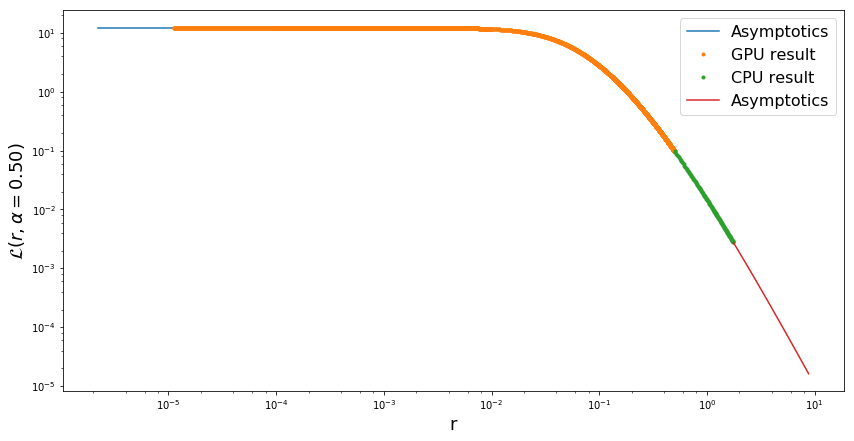

In [233]:
plot(min_r, max_r, grs, gr, crs, cr, alpha)

## Do multiple calculation, show result

In [271]:
alphas, limits, rvals, Lr = generateTable(0.5, 1.99,5)

------------------Calculating for alpha=1.990000 ------------------
*Find GPU r maximum! Target r max =  [ 70.   69.5  69.   68.5  68.   67.5  67.   66.5  66.   65.5  65. ]
  GPU integral error set to  1e-07
->GPU: elapsed time = 1032.0 ms
  CPU integral error set to  1e-10
->CPU: elapsed time = 1689.0 ms
  GPU maximum r = 70.000000, CPU value=0.000000e-5, GPU value=0.000000e-5, DIFF=0.000191e-8
*Asymptotic serie (val=0.000000e-5) diff at max_gpu_r (CPU val=0.000000e-5, GPU val=0.000000e-5): 0.000191e-8
  Asymptotic result equal with GPU result at max_gpu_r (70.000000) with 1.000000e1-8 tolerance!
  max_r set to max_gpu_r =  70.0
*Start GPU integrations in [0.000001, 70.000000] r range, devided to 2560 part!
->GPU: elapsed time = 1190.0 ms
*Asymptotic serie (val=2.256800e-2) diff at min_gpu_r (1.000000e-4) (GPU val=2.256800e-2): 0.064125e-8
  Asymptotic result equal with GPU result at min_gpu_r (1.000000e-4) with 1.000000e1-8 tolerance!
  min_r set to min_gpu_r =  0.0001


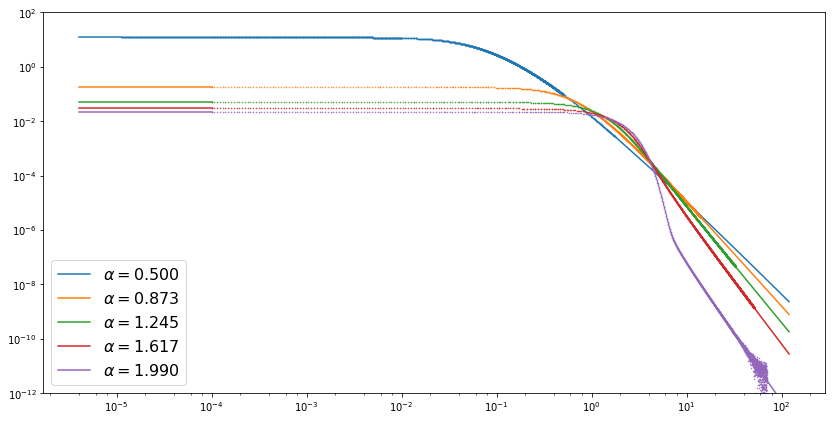

In [273]:
plt.figure(0,(14,7))
plt.ylim([1e-12,100])
for i in range(len(Lr)):
    plt.loglog()
    x = np.linspace(limits[i][1], 120)
    p=plt.plot(x, asym_bx(x,alphas[i]), label=r"$\alpha=%.3f$"%alphas[i])
    x = np.linspace(4e-6,limits[i][0])
    plt.plot(x, asym_sx(x, alphas[i]), c=p[0].get_color())
    plt.plot(rvals[i], Lr[i],'.',ms=1,c=p[0].get_color())
plt.legend(fontsize=16, loc=3)
plt.show()

## Remove extra points

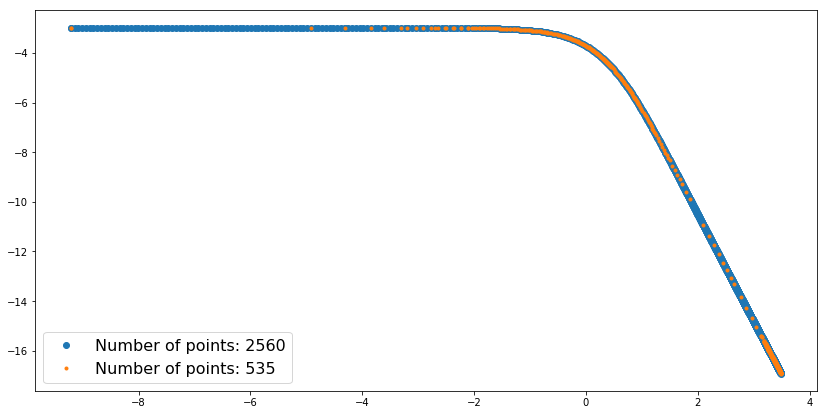

In [279]:
idx=2
new_r, new_Lr = reNumberTable(rvals,Lr)
plt.figure(0,(14,7))
plt.plot(np.log(rvals[idx]), np.log(Lr[idx]), 'o', label="Number of points: "+str(len(rvals[idx])))
new_r, new_Lr = remove_points(np.log(rvals[idx]), np.log(Lr[idx]),1e-4)
plt.plot(new_r, new_Lr, '.', label="Number of points: "+str(len(new_r)))
plt.legend(fontsize=16, loc=3)

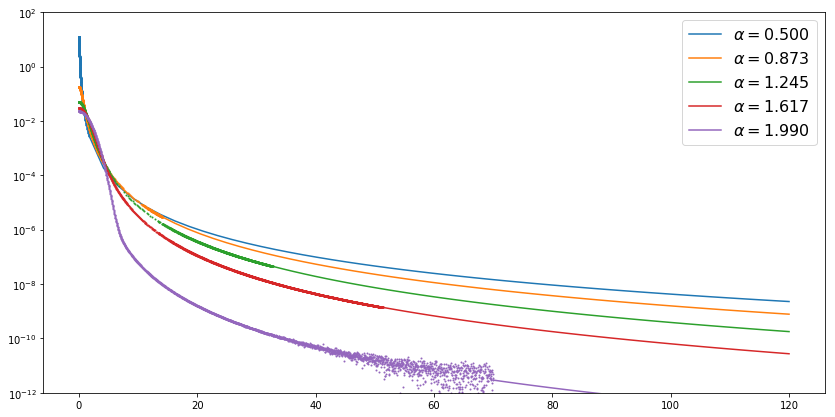

In [276]:
new_r, new_Lr = reNumberTable(rvals,Lr)

plt.figure(0,(14,7))
plt.ylim([1e-12,100])
for i in range(len(Lr)):
    plt.yscale("log")
    x = np.linspace(limits[i][1], 120)
    p=plt.plot(x, asym_bx(x,alphas[i]), label=r"$\alpha=%.3f$"%alphas[i])
    x = np.linspace(4e-6,limits[i][0])
    plt.plot(x, asym_sx(x, alphas[i]), c=p[0].get_color())
    plt.plot(new_r[i], new_Lr[i],'.',ms=2,c=p[0].get_color())
plt.legend(fontsize=16, loc=1)
plt.show()

# Making table

In [283]:
#dalpha = alphas[1]-alphas[0]
#min_alpha = alphas[0]
#alpha[i]  = min_alpha + i*dalpha
#int(np.floor((1.876-min_alpha)/dalpha))

In [6]:
alphas, limits, rvals, Lr = generateTable(0.5, 1.99,5)
rvals, Lr = reNumberTable(rvals,Lr)

------------------Calculating for alpha=1.990000 ------------------
*Find GPU r maximum! Target r max =  [ 70.   69.5  69.   68.5  68.   67.5  67.   66.5  66.   65.5  65. ]
  GPU integral error set to  1e-07
->GPU: elapsed time = 1033.0 ms
  CPU integral error set to  1e-10
->CPU: elapsed time = 1809.0 ms
  GPU maximum r = 70.000000, CPU value=0.000000e-5, GPU value=0.000000e-5, DIFF=0.000191e-8
*Asymptotic serie (val=0.000000e-5) diff at max_gpu_r (CPU val=0.000000e-5, GPU val=0.000000e-5): 0.000191e-8
  Asymptotic result equal with GPU result at max_gpu_r (70.000000) with 1.000000e1-8 tolerance!
  max_r set to max_gpu_r =  70.0
*Start GPU integrations in [0.000001, 70.000000] r range, devided to 2560 part!
->GPU: elapsed time = 1189.0 ms
*Asymptotic serie (val=2.256800e-2) diff at min_gpu_r (1.000000e-4) (GPU val=2.256800e-2): 0.064125e-8
  Asymptotic result equal with GPU result at min_gpu_r (1.000000e-4) with 1.000000e1-8 tolerance!
  min_r set to min_gpu_r =  0.0001


In [11]:
def writeList(f, name, data):
    grp = f.create_group(name)
    for i in range(len(data)):
        grp.create_dataset(str(i), data=data[i])

In [14]:
f = h5.File("Levy.h5", "w")

In [15]:
writeList(f, "rvals", rvals)
writeList(f, "Lr", Lr)
writeList(f, "limits", limits)
grp = f.create_group("/alphas")
grp.create_dataset("dalpha", data=np.array(alphas[1]-alphas[0], np.double))
grp.create_dataset("min_alpha", data=np.array(alphas[0], np.double))
grp.create_dataset("max_alpha", data=np.array(alphas[-1], np.double))
grp.create_dataset("length", data=np.array(len(alphas), np.int))

<HDF5 dataset "length": shape (), type "<i4">

In [24]:
f.close()